In [1]:
import sys
sys.path.append("/home/kelechi.mbibi/CLUSTER/")  


import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from Final_Classifier import MultiModalClassifier, MultiModalDataset, test_loader  # Import model




/home/kelechi.mbibi/software/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model with the same structure as trained
num_classes = 4  
model = MultiModalClassifier(num_classes=num_classes).to(device)

# Load best model weights
model.load_state_dict(torch.load("/home/kelechi.mbibi/CLUSTER/Best_Classifier.pth", map_location=device))
model.eval()  # Set model to evaluation mode

print("Model loaded successfully!")


Model loaded successfully!


In [3]:
# Define loss function for evaluation
criterion = torch.nn.CrossEntropyLoss()

def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask, images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return total_loss / len(test_loader), accuracy, all_preds, all_labels

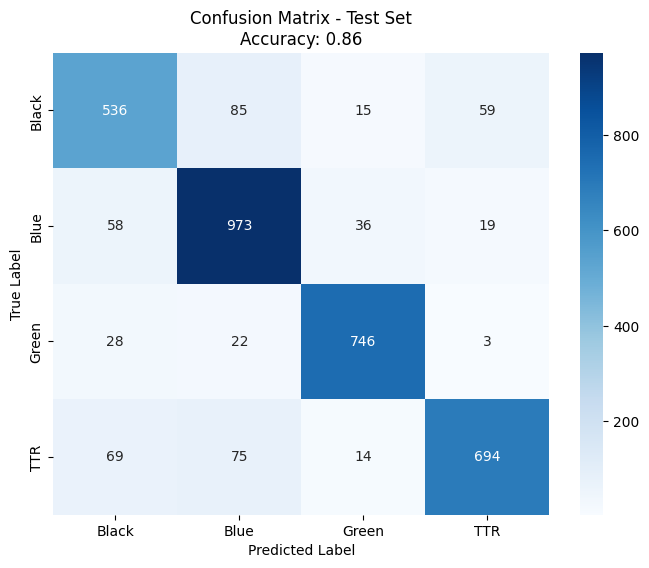

In [4]:
# Run evaluation on the test set
test_loss, test_acc, all_preds, all_labels = evaluate(model, test_loader, criterion, device)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Black", "Blue", "Green", "TTR"], yticklabels=["Black", "Blue", "Green", "TTR"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - Test Set\nAccuracy: {test_acc:.2f}")
plt.show()
